# Ensemble Learning

In last two sections we looked into using ML to either predict a number, or to classify a data into whether it belongs to one group or other. In both the cases, our approach was - use a model, identify how well the accuracy of the model is, and then try to understand the model. But now we live in the age of big data and megaprocessing powers. Today our basic computers pack such a power that we can process gigabytes of data, and then we have the concepts of cloud computing distributed processing. So why limit ourselves to the choice of one model. We can actually build our predictions from a model which is a combination of several models, each suggesting a prediction, and the final prediction is a weighted aggregation of all the individual predictions by the individial models. That is where the true power of machine learning lies - Ensemble learning, where we use, instead of a single model, a group of models, to give us our predictions. This session will introduce three such ensemble lerning approaches:
1. Random Forests
2. Stacking
3. Boosting

## Random Forests

Random forests are one of the more common types of ensemble learning algorithms. The concept of random forest derives from trees. We previously used tree based methods to make predictions of spending amount of customers, or to make predictions of whether a loan application is likely to default or not. A forest is a collection of trees! So basically, instead of a single tree, we fit multiple trees with the data. But how can you fit multiple trees using the same algorithm for the same data?

Simple! We first start with a subset of the training dataset, both in terms of columns and rows. Which means, from the full training dataset, we take some random rows of data where also some random columns are selected. Then we fit a tree. We do this many times (100s, or 1000s), each time selected a subset of rows and columns, and each time fitting a single tree model. So we end up with 100s or 1000s of trees, a forest. Then for our prediction, instead of choosing from one single tree, we take the prediction of single datapoint for each and every single tree, and then we average the 100s or 1000s of prediction together to get our predicted value. Sounds familiar? This is basically the concept of the wisdom of the crowds - some models will be very extreme, but when all the models' outputs are brought together, the prediction becomes. Also the beauty of the random forest approach is that helps in preventing overfitting in models - since each tree is fitted differently in some different form of data, one of two of the trees might overfit, but overall, other trees will reduce the domination of the overfitted trees.

Enough about the theory. If you want to know more about random forests, one good video would be - https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&t=248s

Lets start by loading our usual libraries and then the data

In [1]:
# Starting with Pandas
import pandas as pd

# The setting up the place for visualizations
pd.plotting.register_matplotlib_converters()

import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

# Importing the sys library for installing packages when we will need them
import sys

# Importing numpy if we need to work with numeric calculations
import numpy as np

# Finally loading the data - for this session we will stick with the Credit Default dataset
loandata = pd.read_csv("/Users/muhammadsaqifulalam/Dropbox/My Mac (FVFD1URVP3XY)/Desktop/credit_risk_dataset.csv")

# Taking a peek at the data
loandata.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Now based on our learning from the previous session we will clean the data accordingly, kick out the outliers of the income, age and employment lenght, and then drop the missing values and the duplicates

In [2]:
# Removing the outliers in one go
loandata = loandata[(loandata["person_income"] <= 1000000) & (loandata["person_age"] <= 80) & (loandata["person_emp_length"] <= 60)]

# Dropping the imssing values
loandata = loandata.dropna()

# Dropping duplicates
loandata = loandata.drop_duplicates()

# Finally, checking what is the dimensions of the data
loandata.shape

(28488, 12)

Next, we rebalance the dataset, to create a dataset where one third of the applications defaulted, and two thirds did not default

In [3]:
# Taking out the defaulters
defs = loandata[loandata["loan_status"] == 1]

# Taking out the non-defaulters
nondefs_full = loandata[loandata["loan_status"] == 0]

# Created a sample of non defs who are twice the size of defs
nondefs_sample = nondefs_full.sample(n = (2 * len(defs)))

# Joining the datasets together
finaldata = pd.concat([defs, nondefs_sample])

# Shuffling the whole dataset
finaldata = finaldata.sample(n = len(finaldata))

# Removing the index column auto craeted when we sampled
finaldata = finaldata.reset_index(drop = True)

# Finally taking a peek at the new final dataset
finaldata.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,26,75000,MORTGAGE,4.0,DEBTCONSOLIDATION,B,21000,11.48,0,0.28,N,4
1,21,40000,MORTGAGE,5.0,MEDICAL,A,9000,7.51,0,0.23,N,4
2,23,45480,MORTGAGE,7.0,DEBTCONSOLIDATION,C,4400,13.16,1,0.10,N,3
3,24,70399,RENT,0.0,DEBTCONSOLIDATION,A,1000,8.59,0,0.01,N,2
4,22,36000,RENT,3.0,EDUCATION,A,4000,5.42,0,0.11,N,2


In [4]:
# Confirming that the rebalancing was successful
finaldata.loan_status.mean()

0.3333333333333333

Now, we will prepare the dataset by one hot encoding and then scaling using min max scaler

In [5]:
# One hot encoding to transform the categorical variables to numeric counterparts
finaldata_dummies = pd.get_dummies(finaldata)

# Importing the Min Max scaler from Sklearn
from sklearn.preprocessing import MinMaxScaler

# Creating the scaler object
scaler = MinMaxScaler()

# Fitting the scaler to the data to craete a scaled array
scaled = scaler.fit_transform(finaldata_dummies)

# Converting the scaled array to our dataset
finaldata_scaled = pd.DataFrame(scaled, columns = finaldata_dummies.columns)

# Taking a peek at the data
finaldata_scaled.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,0.100000,0.079241,0.097561,0.594203,0.340449,0.0,0.337349,0.071429,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.016667,0.040179,0.121951,0.246377,0.117416,0.0,0.277108,0.071429,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.050000,0.046295,0.170732,0.113043,0.434831,1.0,0.120482,0.035714,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.066667,0.074106,0.000000,0.014493,0.178090,0.0,0.012048,0.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.033333,0.035714,0.073171,0.101449,0.000000,0.0,0.132530,0.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Phew! Quite a lot of steps to get ourselves prepared for the analysis of this data. But that is good, it shows how much we have covered in the last few sessions, when we did all these things. We are left with one last step, before we jump in fitting our models. We need to create the Train and Test Splits. Lets do them next

In [6]:
# Importing the train test splittter
from sklearn.model_selection import train_test_split

# Dropping the loan status from the final data to make it the X set
X = finaldata_scaled.drop("loan_status", axis = 1)

# Creating the Y by just taking the loan status
Y = finaldata_scaled["loan_status"]

# Creating the X and Y test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

# Checking whether we got the desired results
print(X_train.shape, X_test.shape, len(Y_train), len(Y_test))

(12992, 26) (5569, 26) 12992 5569


Now we are fully equipped to fit our random forest model. The steps to run this models is exactly the same as any other ML models we have seen using the SKlearn library. This is the beauty of Sklearn in python, it standardizes ML in a way that you can easily go through many models without much of a change in preparations

In [7]:
# Loading the Random Forest function
from sklearn.ensemble import RandomForestClassifier

# Creating a forest object with 100 trees
rf100 = RandomForestClassifier(n_estimators = 100)

# Fitting the model
rf100.fit(X_train, Y_train)

# Making top 5 predictions of the X_test, and also the probabilities
print(rf100.predict(X_test.head()), rf100.predict_proba(X_test.head()))

[0. 0. 0. 0. 0.] [[0.87 0.13]
 [0.81 0.19]
 [0.52 0.48]
 [0.75 0.25]
 [0.99 0.01]]


Next, we can check both the confusion matrix and the accuracy, precision and recall to decide on the model performance

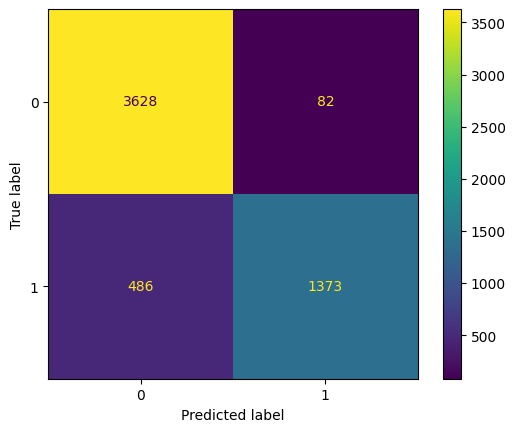

In [8]:
# Importing the functions to create the confusion matrix and to plot it
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Creating the Matrix
cm = confusion_matrix(y_true = Y_test, y_pred = rf100.predict(X_test))

# Plotting the Matrix
ConfusionMatrixDisplay(cm).plot()

In [9]:
# Importing the function to get accuracy, precision and recall
from sklearn.metrics import classification_report

# Creating and printing the report
print(classification_report(y_true = Y_test, y_pred = rf100.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93      3710
         1.0       0.94      0.74      0.83      1859

    accuracy                           0.90      5569
   macro avg       0.91      0.86      0.88      5569
weighted avg       0.90      0.90      0.89      5569



So we can see that the model is overall more accurate (from 84% before to 90% now). But the challenge is in Recall, which has gone down from the single tree model, though there is a very high increase in precision, almost 20%. Whats happening here is that when we are putting many trees together, the algorithm is undestanding its easier to make sure we dont call any non defaulters to be a potential defaulter. Also this is an indication that the previous model we trained (a single tree) could be overfitting.

Now, a question can be, how large should the forest be - 10 trees? 50 trees? 100? 250? 500? 1000? The beauty of programming is we can check exactly that, using a for loop

In [10]:
# Lets create a report object, where we store the classification report
report = classification_report(y_true = Y_test, y_pred = rf100.predict(X_test), output_dict = True)

# As you can see, we have added a new parameter, which will give us the output in the form of a dictionary, similar
# to that of a dataframe, from where we can call for the certain variables.

# Printing Accuracy, Precision of 1 and Recall of 1
print(report["accuracy"], report["1.0"]["precision"], report["1.0"]["recall"])

0.8980068234871611 0.9436426116838488 0.7385691231845078


So the logic is, if we can get these numbers separately, we can try out the following looped approach:
1. Create a list of number of trees we want to create
2. Loop through the number of trees to create the forests
3. For each of the forest, calculate Accuracy, Precision and Recall
4. Create a dataframe with all these information, to check at which point the Accuract, Precision and Recall are the most desirable

In [11]:
# Creating the list of the trees
tree_size = [10, 50, 100, 250, 500, 1000]

# Creating the empty lists
accuracy = []
precision = []
recall = []

# Creating the loop
for tree in tree_size:
    rf = RandomForestClassifier(n_estimators = tree)
    rf.fit(X_train, Y_train)
    predictions = rf.predict(X_test)
    report = classification_report(y_true = Y_test, y_pred = predictions, output_dict = True)
    accuracy.append(report["accuracy"])
    precision.append(report["1.0"]["precision"])
    recall.append(report["1.0"]["recall"])


In [12]:
# Combining the tree numbers with the other metrics
dict = {"tree_size" : tree_size, "accuracy" : accuracy, "precision" : precision, "recall" : recall}

# Creating the dataframe
rf_optim = pd.DataFrame(dict)

# Looking at the data
rf_optim

,tree_size,accuracy,precision,recall
0,10,0.889208,0.925926,0.726197
1,50,0.895493,0.940041,0.733728
2,100,0.896391,0.938440,0.738031
3,250,0.896750,0.940329,0.737493
4,500,0.898725,0.949965,0.735342
5,1000,0.898546,0.945592,0.738569


<AxesSubplot:>

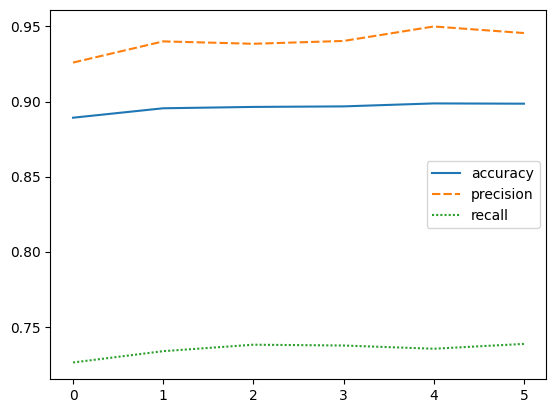

In [13]:
# Plotting the outcome of accuracy, precision and recall, to see how the results look like
sns.lineplot(data = rf_optim.drop("tree_size", axis = 1))

This chart tells us by the 3rd tree length (100) the results are steady and there is no further gain in any of the metrics. So we can keep our forest to be 100, instead of 1000, as that will increase our processing time without giving us much of a gain in any of our predictive power.

So we have not only learned how to fit a forest, but actually how to identify the optimal forest size, and it wasnt that hard!

## Boosting

Another method which makes use of processing power in our computers is the boosting algorithm. The concept of boosting is also not very complex. The idea is, first up, the algorithm fits a very simple model, called the Naive Bayes mdoel. Then this model is used to make some preliminary predictions. Then the algorithm will check the how much is the error of these predictions. Then the algorithm will automatically improve the model to reduce the errors. This is like a cycle, where this will go on until there is no more improvement to be gained in the new model. THe final model will be the boosted model. The beauty of boosting is that it creates a model that caters to making the best prediction possible.

Some more details about boosting can be seen here - https://www.youtube.com/watch?v=8b1JEDvenQU&list=PLZ5DHV9_5h9vQwAImmNi1RfoTtSuOUjwM&index=17

We will start with fitting a simple boosting model, using the fucntion called XGboost in Python. Then next we will step by step look into how we can improve on our boosting model


In [20]:
# Installing the xgboost libray
!{sys.executable} -m pip install xgboost

# Importing the xgboost function
from xgboost import XGBClassifier

# Creating the model object
basic_xgb = XGBClassifier()

# Fitting the classifier
basic_xgb.fit(X_train, Y_train)

# Printing some predictions
print(basic_xgb.predict(X_test.head()), basic_xgb.predict_proba(X_test.head()))

[0 0 0 0 0] [[9.9493110e-01 5.0688880e-03]
 [8.8661242e-01 1.1338759e-01]
 [6.8417829e-01 3.1582171e-01]
 [8.4646964e-01 1.5353036e-01]
 [9.9979037e-01 2.0964109e-04]]


Lets see how the XGboosted model fares with the test dataset

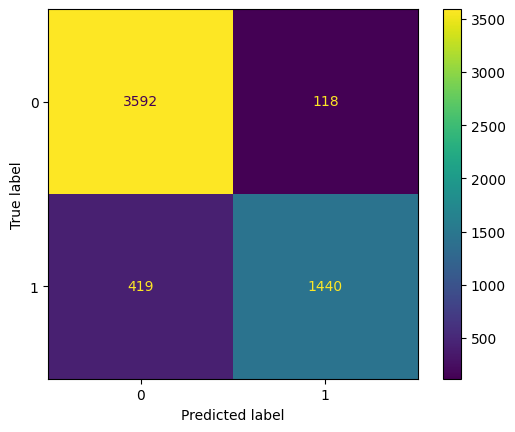

In [21]:
# Generating the full list of predictions
preds = basic_xgb.predict(X_test)

# Creating a confusion matrix
cm = confusion_matrix(y_true = Y_test, y_pred = preds)

# Plotting the confusion matrix
ConfusionMatrixDisplay(cm).plot()

In [22]:
# Printing out the classification report
print(classification_report(y_true = Y_test, y_pred = preds))

              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93      3710
         1.0       0.92      0.77      0.84      1859

    accuracy                           0.90      5569
   macro avg       0.91      0.87      0.89      5569
weighted avg       0.91      0.90      0.90      5569



From this result we can see that overall accuracy is similar to random forests, but the refcall scores for predicting the true defaulters.

Two of the things we can add to the xgboosting is the number of times it needs to run the cycle, and should it stop early if it gets the best possible result. These together can help us fine tune our model a lot of iterations, but also helps us save processing power by reducing the number of cycles required by ending early if the most optimum result is reached. Lets see how we can add them to the xgboost function

In [24]:
# Creating the xgboost model with 1000 iterations
finetuned_xgb = XGBClassifier(n_estimators = 1000)

# Fitting the model to the data
finetuned_xgb.fit(X_train, Y_train, early_stopping_rounds = 10, eval_set = [(X_test, Y_test)])

# Generating some predictions
print(finetuned_xgb.predict(X_test.head()), finetuned_xgb.predict_proba(X_test.head()))

[0]	validation_0-logloss:0.53281
[1]	validation_0-logloss:0.44846
[2]	validation_0-logloss:0.39615
[3]	validation_0-logloss:0.36273
[4]	validation_0-logloss:0.33923
[5]	validation_0-logloss:0.32457


/Users/muhammadsaqifulalam/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.31420
[7]	validation_0-logloss:0.30583
[8]	validation_0-logloss:0.30024
[9]	validation_0-logloss:0.29238
[10]	validation_0-logloss:0.28884
[11]	validation_0-logloss:0.28613
[12]	validation_0-logloss:0.28279
[13]	validation_0-logloss:0.27651
[14]	validation_0-logloss:0.27405
[15]	validation_0-logloss:0.27248
[16]	validation_0-logloss:0.27121
[17]	validation_0-logloss:0.26890
[18]	validation_0-logloss:0.26862
[19]	validation_0-logloss:0.26581
[20]	validation_0-logloss:0.26487
[21]	validation_0-logloss:0.26220
[22]	validation_0-logloss:0.25983
[23]	validation_0-logloss:0.25970
[24]	validation_0-logloss:0.25789
[25]	validation_0-logloss:0.25602
[26]	validation_0-logloss:0.25484
[27]	validation_0-logloss:0.25424
[28]	validation_0-logloss:0.25456
[29]	validation_0-logloss:0.25421
[30]	validation_0-logloss:0.25381
[31]	validation_0-logloss:0.25330
[32]	validation_0-logloss:0.25289
[33]	validation_0-logloss:0.25254
[34]	validation_0-logloss:0.25186
[35]	validation_0-

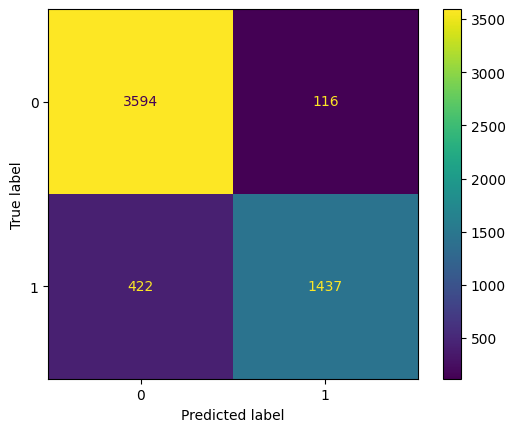

In [28]:
# Generating the predictioms
preds = finetuned_xgb.predict(X_test)

# Checking the confusion matrix for the new model
cm = confusion_matrix(y_pred = preds, y_true = Y_test)

# Plotting the Confusion matrix
ConfusionMatrixDisplay(cm).plot()

In [29]:
# Printing out the Classification Report
print(classification_report(y_true = Y_test, y_pred = preds))

              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93      3710
         1.0       0.93      0.77      0.84      1859

    accuracy                           0.90      5569
   macro avg       0.91      0.87      0.89      5569
weighted avg       0.91      0.90      0.90      5569



Very similar performance to that of the previous model. Seems like this is the best that both the boosting and the random forests can do. We can finally move on to the final and most powerful ensemble learning approach - Stacking!

## Stacking - Why not have everything?

As the section header puts it, Stacking in a collecting of everything! That means instead of having to chose between a regression, or a tree, or many trees, or boosting, what we can have is a stack of all of these. That is simply the concept of stacking. Here we declare the models we want to fit our data, and then what the stacking algorithm does is first it fits the each of the models individually, and then combines the outcomes of this models with another model to finally make the prediction. The power of stacking is that its the optimal combination of all the models that we have used so far and will focus on taking the best from each of these models, so we really dont miss out on any single front.

Lets stack!

In [38]:
# First we start by importing the Logit and Tree model. The Random forest and the xgboost model are already loaded
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Then we importing the stacking function
from sklearn.ensemble import StackingClassifier

# Next, we create a list of models that we want to stack!
estimators = [('logit', LogisticRegression(max_iter = 1000)), ('tree', DecisionTreeClassifier()), ('randomforest', RandomForestClassifier(n_estimators = 100)), ('xgboost', XGBClassifier(n_estimators = 500))]

# Finally, with that list, we craete the stacking model object
stack = StackingClassifier(estimators = estimators)

# Then we mid the model to the data
stack.fit(X_train, Y_train)

# Finally we can look at some of the predictions
print(stack.predict(X_test.head()), stack.predict_proba(X_test.head()))


[0. 0. 0. 0. 0.] [[0.93837549 0.06162451]
 [0.90751876 0.09248124]
 [0.60451071 0.39548929]
 [0.82697825 0.17302175]
 [0.96119389 0.03880611]]


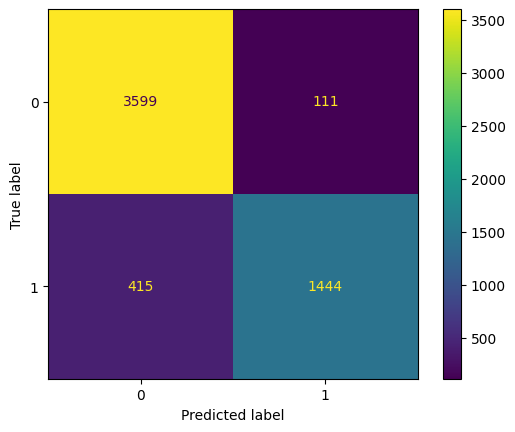

In [39]:
# Now we generate the predictions
preds = stack.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_pred = preds, y_true = Y_test)

# Print the cnfusion matrix
ConfusionMatrixDisplay(cm).plot()

In [40]:
# And printing the classification metrics report
print(classification_report(y_true = Y_test, y_pred = preds))

              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93      3710
         1.0       0.93      0.78      0.85      1859

    accuracy                           0.91      5569
   macro avg       0.91      0.87      0.89      5569
weighted avg       0.91      0.91      0.90      5569



So we can now see that the accuracy have gone up by 1% more, to 91%, which is a big leap from 84% in the last session. Also we have a good precision, 93%, so we are only overkilling 7 out of 100 pplications, but our recall is still a bit low, 78%, which means that we are still going to give 22 out of 100 defaulters the loan.

But this is where we can do something more interesting. If you have so far checked, we always have looked into the probabilities of the predictions, and we saw that the way the models decide whether you are a defaulter or not is when the probability crosses 50%. So if the prob of 0 is 30% then the prediction is 1. If the prob of 0 is 60%, then the prediction is 0. But what if the bank wanted to to be more conservative. Say anyone with a 30% chance of being 1 will be considered as a defaulter? We can still check our models performance for that, we will need to manuall create the cutoff point here

In [47]:
# Instead of gettings the 0/1 predictions, we get the probability of 0 and 1 as predictions
prob_preds = stack.predict_proba(X_test)

# Then we convert the probability into dataframe with the columns non default (0) amd default (1)
prob_preds = pd.DataFrame(prob_preds, columns = ["Non_dfault", "Default"])

# Taking a peek at the pobability prediction 
prob_preds.head()

,Non_dfault,Default
0,0.938375,0.061625
1,0.907519,0.092481
2,0.604511,0.395489
3,0.826978,0.173022
4,0.961194,0.038806


In [51]:
# Creating a new column, status, which gets to be 1 if the default prob is greater than 0.3, or 0 if its less than or equal to 0.3
prob_preds["status"] = pd.cut(prob_preds["Default"], bins = [0, 0.3, 1], labels = [0, 1])

# Taking a peek at the added column
prob_preds.head()

,Non_dfault,Default,status
0,0.938375,0.061625,0
1,0.907519,0.092481,0
2,0.604511,0.395489,1
3,0.826978,0.173022,0
4,0.961194,0.038806,0
...,...,...,...
5564,0.949439,0.050561,0
5565,0.957707,0.042293,0
5566,0.839116,0.160884,0
5567,0.935249,0.064751,0


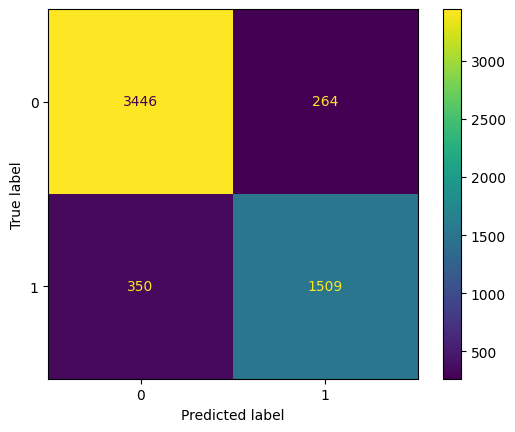

In [52]:
# Now lets make the predictions of the model the status of our prob pred table, which we generated from the model
preds = prob_preds["status"]

# Create the confusion matrix
cm = confusion_matrix(y_pred = preds, y_true = Y_test)

# Print the cnfusion matrix
ConfusionMatrixDisplay(cm).plot()

In [53]:
# And printing the classification metrics report
print(classification_report(y_true = Y_test, y_pred = preds))

              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      3710
         1.0       0.85      0.81      0.83      1859

    accuracy                           0.89      5569
   macro avg       0.88      0.87      0.87      5569
weighted avg       0.89      0.89      0.89      5569



As we can see from the confusion matrix and the classification report that our precision of predicting default have gone down, that is we are overkilling more, BUT, our recall have increased, we are giving out lesser loans to those who are most likely to predict! So there is a loss of overkilling - not giving out loans to those who are potential non-defaulters, but there is a gain in lesser leakage - those who are defaulters, more of them are being correctly identified.

In fact, thanks to programming, we can create a decision landscape here - we can declare anyone as a defaulter from any values from 10% chance of default to 90% chance of default, and then observe the scores of accuracy, precision and recall, to think through where should we set the cut off point. This can easily be achieved through looping!

In [67]:
# First we start by creating a range of values from 0.1 to 0.9, with 0.1 gap between each value
default_cutoff = list(np.arange(0.1, 1, 0.1))

# Notice that we are using numpy's a-range function instead of range function of base python. This is because range
# of base python can only create a range among integers. So we are using the numpy function. The problem with the 
# numpy function is that it returns arrays, another data format. But that can easily be fixed by forcing it to be list
# by adding a list() in front

# Next we create the empty variables of Accuracy, Precision and Recall
Accuracy = []
Precision = []
Recall = []

# Next we create our loop

for cutoff in default_cutoff:
    preds = pd.cut(prob_preds["Default"], bins = [0, cutoff, 1], labels = [0,1])
    class_report = classification_report(y_true = Y_test, y_pred = preds, output_dict = True)
    Accuracy.append(class_report["accuracy"])
    Precision.append(class_report["1.0"]["precision"])
    Recall.append(class_report["1.0"]["recall"])


# Next we create a dictionary where we store these lists
metrics_dict = {"Cutoff" : default_cutoff, "Accuracy" : Accuracy, "Precision" : Precision, "Recall" : Recall}

# Converting the dictionary to a dataframe
metrics = pd.DataFrame(metrics_dict)

# Taking a look at the dataframe
metrics

,Cutoff,Accuracy,Precision,Recall
0,0.1,0.791884,0.629918,0.912856
1,0.2,0.870174,0.782869,0.845616
2,0.3,0.889747,0.851100,0.811727
3,0.4,0.901598,0.898480,0.795051
4,0.5,0.905549,0.928617,0.776762
5,0.6,0.906806,0.949664,0.761162
6,0.7,0.905010,0.964385,0.742873
7,0.8,0.903214,0.979651,0.725121
8,0.9,0.894595,0.991499,0.690156


We can draw a line chart with this dataset to get an idea of where should we draw the line of which of the loans will be a default and which will be non defaulting

/var/folders/ch/knjch20d5hs4_jb_jrm51rgw0000gq/T/ipykernel_91171/2201321781.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(round(metrics["Cutoff"], ndigits=2))


[Text(-1.0, 0, '0.1'),
 Text(0.0, 0, '0.2'),
 Text(1.0, 0, '0.3'),
 Text(2.0, 0, '0.4'),
 Text(3.0, 0, '0.5'),
 Text(4.0, 0, '0.6'),
 Text(5.0, 0, '0.7'),
 Text(6.0, 0, '0.8'),
 Text(7.0, 0, '0.9'),
 Text(8.0, 0, ''),
 Text(9.0, 0, '')]

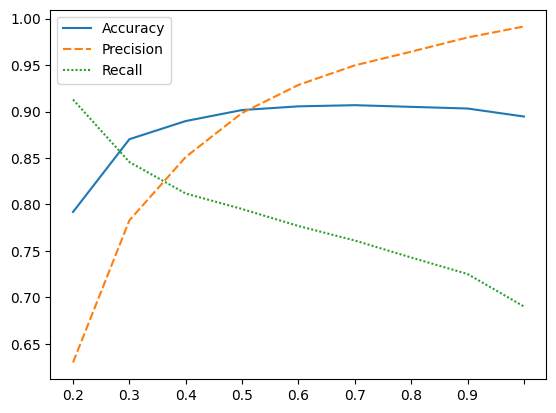

In [76]:
# Lineplot of the metrics
chart = sns.lineplot(data = metrics.drop("Cutoff", axis = 1))
chart.set_xticklabels(round(metrics["Cutoff"], ndigits=2))

This chart actually confirms that if Recall and Accuracy are an issue, then we should be decalring anyone above 30% chance of default to be a defaulter. On the other hand, if Precision and Accuracy is our focus, then we can cut off at 0.5. Finally if we are focused on making sure that we do not miss out a good loan, focusing only on precision, then we should be marking those with 90% chance of above as defaulters only, in which case we will not overkill many loans (less than 5%) but will be giving out loans to many people who are potentially defaulters (almost 25%)